from google.colab import drive
drive.mount('/content/drive')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp '/content/drive/MyDrive/Colab Notebooks/DL/hw4p1/hw4/tests.py' .

In [3]:
!pip install pytorch-nlp
!pip install xeus-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 7.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 32.9 MB/s 
     |████████████████████████████████| 1.8 MB 58.1 MB/s 
     |████████████████████████████████| 793 kB 49.9 MB/s 
     |████████████████████████████████| 381 kB 5.2 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
  Attempting uninstall: debugpy
    Found existing installation: debugpy 1.0.0
    Uninstalling debugpy-1.0.0:
      Successfully uninstalled debugpy-1.0.0
ERROR: pip's dep

In [16]:
%cd '/content/drive/MyDrive/Colab Notebooks/DL/hw4p1/dataset'

/content/drive/MyDrive/Colab Notebooks/DL/hw4p1/dataset


In [17]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests import test_prediction, test_generation
from torch.nn import Parameter
import torch.optim as optim
from tqdm import tqdm
import warnings
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [18]:
# load all that we need
dataset = np.load('../dataset/wiki.train.npy', allow_pickle=True) # training data
fixtures_pred = np.load('../fixtures/prediction.npz')  # data for prediction() from the `dev` set
fixtures_gen = np.load('../fixtures/generation.npy')  # input for generation() from the `dev` set
fixtures_pred_test = np.load('../fixtures/prediction_test.npz') # data for prediction() from the test set
fixtures_gen_test = np.load('../fixtures/generation_test.npy')  # input for generation() from the test set
vocab = np.load('../dataset/vocab.npy') # a NumPy file containing the words in the vocabulary

In [19]:
#%%
# data loader
class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
      self.dataset =  dataset
      self.batch_size = batch_size
      self.shuffle = shuffle

    def __iter__(self):
        if self.shuffle: np.random.shuffle(self.dataset)
        # concatenate your articles and build into batches
        #Concatenate all text in one long string.
        con_dataset = np.hstack(dataset)
        #a random BPTT length which is N(70, 5) with probability 0.95 and N(35, 5) with probability 0.05.
        i = 0
        while (1):
            bptt_len = np.random.choice([int(np.random.normal(70, 5)), int(np.random.normal(35, 5))], p=[0.95, 0.05])
            if i < (len(con_dataset) - (self.batch_size* bptt_len) -1):
                batch_in = con_dataset[i: i+(self.batch_size* bptt_len)].reshape(self.batch_size, bptt_len)
                target = con_dataset[i+1: i+1+(self.batch_size* bptt_len)].reshape(self.batch_size, bptt_len)
                yield torch.from_numpy(batch_in).long().to(device), torch.from_numpy(target).long().to(device)
                i += (self.batch_size* bptt_len)
            else: 
                break

In [20]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim , dropout = 0.0, weight_init = 0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim  = embedding_dim  
        self.dropout = dropout
        self.weight = nn.Parameter(torch.empty(vocab_size, embedding_dim, device=device))
        #All embedding weights were uniformly initialized in the interval [−0.1, 0.1] 
        nn.init.uniform_(self.weight, -weight_init, weight_init)
                     
    def forward(self, x):
        if self.training:
          mask = torch.empty(self.vocab_size, 1, device = x.device).bernoulli_(1-self.dropout)/(1-self.dropout)
          mask = mask.expand_as(self.weight)
          weight = mask*self.weight
          return weight[x]
        else: return self.weight[x]

In [21]:
class LockedDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
    def forward(self, x):
        if not self.training or not self.p:
            return x
        mask = torch.empty(*x.shape[-2:], requires_grad=False, device = x.device).bernoulli_(1 - self.p)/(1 - self.p)
        mask = mask.expand_as(x)
        return mask * x

In [22]:
class Weight_Tying(nn.Module):
    def __init__(self, embed_size, out_size, embed_weight):
        super().__init__()
        self.embed_size = embed_size
        self.out_size = out_size
        self.embed_weight = embed_weight
        self.module = nn.Linear(self.embed_size, self.out_size, device=device)
        b_init = 1.0/np.sqrt(self.out_size)
        nn.init.uniform_(self.module._parameters['bias'], -b_init, b_init)
        self.module._parameters['weight'] = embed_weight
    def forward(self, *args, **kwargs):
        return self.module.forward(*args, **kwargs)

In [23]:
class LanguageModel(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size):
        super().__init__()
        #embedding dropout 
        self.embedding = Embedding(vocab_size=vocab_size, embedding_dim=400, dropout = 0.1)
        self.embedding_dp = LockedDropout(p=0.4)
        self.out_dp = LockedDropout(p=0.4)
        #three-layer LSTM model with 1150 units in the hidden layer and an embedding of size 400.
        self.lstm = nn.LSTM(input_size=400, hidden_size=1150, num_layers=3, batch_first = True, device=device, proj_size=400, dropout=0.5)
        #Weight tying (Inan et al., 2016; Press &Wolf, 2016) shares the weights between the embedding and softmax layer
        self.out = Weight_Tying(400, vocab_size, self.embedding.weight) 
    def forward(self, x, hidden=None):
        x = self.embedding(x)
        x = self.embedding_dp(x)
        x, h = self.lstm(x, hidden) if hidden else self.lstm(x)
        x = self.out_dp(x)
        hidden= h
        out = self.out(x)
        return out, hidden

In [24]:
# model trainer

class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, weight_decay=1e-6)
        self.criterion = nn.CrossEntropyLoss()
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        for batch_num, (inputs, targets) in enumerate(self.loader):
            epoch_loss += self.train_batch(inputs, targets)
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
        
        """
        self.optimizer.zero_grad()
        predict,_ = self.model(inputs) 
        loss = self.criterion(predict.view(-1, predict.shape[2]), targets.view(-1)) 
        loss.backward()
        self.optimizer.step()
        return loss

    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions for `dev`
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words for `dev`
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)  # generated predictions for 10 words for `test`
        nll = test_prediction(predictions, fixtures_pred['out']) # Negative Log Likelihood (NLL) on the dev set for prediction
        generated = test_generation(fixtures_gen, generated_logits, vocab) # generated sequence for `dev`
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab) # generated sequence for `test`
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions for `test`
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, nll))
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [25]:
class TestLanguageModel:
    def prediction(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """  
        inp = torch.from_numpy(inp).long().to(device)
        out,_ = model(inp)
        return out[:,-1,:].cpu().detach().numpy()

        
    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """   
        model.eval()
        inp = torch.from_numpy(inp).long().to(device)
        with torch.no_grad():
            h = None
            generated_words = []
            for i in range(forward):                           
                out, h = model(inp, h)
                out = out[:,-1,:].argmax(1)
                inp = torch.cat((inp, out.unsqueeze(1)), 1)
                generated_words.append(out.cpu().detach().numpy())
        generated_words = np.stack(generated_words, 1)
        return generated_words

In [26]:
# TODO: define other hyperparameters here

NUM_EPOCHS = 50
BATCH_SIZE = 80

In [27]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1660560996


In [28]:
model = LanguageModel(len(vocab)).to(device)
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)

In [29]:
start=0
best_nll = 1e30 
for epoch in tqdm(range(start, start+NUM_EPOCHS)):
    trainer.train()
    nll = trainer.test()
    trainer.scheduler.step(nll)
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save() 

  0%|          | 0/50 [00:00<?, ?it/s]

[TRAIN]  Epoch [2/50]   Loss: 7.1620
[VAL]  Epoch [2/50]   Loss: 5.8730
Saving model, predictions and generated output for epoch 0 with NLL: 5.8730087


  2%|▏         | 1/50 [02:14<1:50:00, 134.69s/it]

[TRAIN]  Epoch [3/50]   Loss: 6.4461
[VAL]  Epoch [3/50]   Loss: 5.5622
Saving model, predictions and generated output for epoch 1 with NLL: 5.562196


  4%|▍         | 2/50 [04:38<1:52:00, 140.02s/it]

[TRAIN]  Epoch [4/50]   Loss: 6.1550
[VAL]  Epoch [4/50]   Loss: 5.2079
Saving model, predictions and generated output for epoch 2 with NLL: 5.2079177


  6%|▌         | 3/50 [07:06<1:52:28, 143.59s/it]

[TRAIN]  Epoch [5/50]   Loss: 5.9416
[VAL]  Epoch [5/50]   Loss: 4.9592
Saving model, predictions and generated output for epoch 3 with NLL: 4.959221


  8%|▊         | 4/50 [09:35<1:51:54, 145.96s/it]

[TRAIN]  Epoch [6/50]   Loss: 5.7682
[VAL]  Epoch [6/50]   Loss: 4.8162
Saving model, predictions and generated output for epoch 4 with NLL: 4.8162184


 10%|█         | 5/50 [12:05<1:50:26, 147.26s/it]

[TRAIN]  Epoch [7/50]   Loss: 5.6331
[VAL]  Epoch [7/50]   Loss: 4.6529
Saving model, predictions and generated output for epoch 5 with NLL: 4.6529293


 12%|█▏        | 6/50 [14:35<1:48:47, 148.34s/it]

[TRAIN]  Epoch [8/50]   Loss: 5.5093
[VAL]  Epoch [8/50]   Loss: 4.6012
Saving model, predictions and generated output for epoch 6 with NLL: 4.601205


 14%|█▍        | 7/50 [17:05<1:46:43, 148.91s/it]

[TRAIN]  Epoch [9/50]   Loss: 5.4032
[VAL]  Epoch [9/50]   Loss: 4.5504
Saving model, predictions and generated output for epoch 7 with NLL: 4.5504246


 16%|█▌        | 8/50 [19:36<1:44:30, 149.29s/it]

[TRAIN]  Epoch [10/50]   Loss: 5.3185


 18%|█▊        | 9/50 [22:05<1:42:07, 149.45s/it]

[VAL]  Epoch [10/50]   Loss: 4.5866
[TRAIN]  Epoch [11/50]   Loss: 5.2348


 20%|██        | 10/50 [24:35<1:39:42, 149.56s/it]

[VAL]  Epoch [11/50]   Loss: 4.5563
[TRAIN]  Epoch [12/50]   Loss: 5.1660
[VAL]  Epoch [12/50]   Loss: 4.5393
Saving model, predictions and generated output for epoch 10 with NLL: 4.539317


 22%|██▏       | 11/50 [27:05<1:37:19, 149.72s/it]

[TRAIN]  Epoch [13/50]   Loss: 5.1044
[VAL]  Epoch [13/50]   Loss: 4.5012
Saving model, predictions and generated output for epoch 11 with NLL: 4.501224


 24%|██▍       | 12/50 [29:36<1:34:57, 149.95s/it]

[TRAIN]  Epoch [14/50]   Loss: 5.0543
[VAL]  Epoch [14/50]   Loss: 4.4277
Saving model, predictions and generated output for epoch 12 with NLL: 4.4277406


 26%|██▌       | 13/50 [32:07<1:32:39, 150.26s/it]

[TRAIN]  Epoch [15/50]   Loss: 4.9892
[VAL]  Epoch [15/50]   Loss: 4.3846
Saving model, predictions and generated output for epoch 13 with NLL: 4.38455


 28%|██▊       | 14/50 [34:38<1:30:16, 150.45s/it]

[TRAIN]  Epoch [16/50]   Loss: 4.9381
[VAL]  Epoch [16/50]   Loss: 4.3341
Saving model, predictions and generated output for epoch 14 with NLL: 4.334116


 30%|███       | 15/50 [37:09<1:27:58, 150.82s/it]

[TRAIN]  Epoch [17/50]   Loss: 4.8938


 32%|███▏      | 16/50 [39:40<1:25:27, 150.82s/it]

[VAL]  Epoch [17/50]   Loss: 4.3680
[TRAIN]  Epoch [18/50]   Loss: 4.8532
[VAL]  Epoch [18/50]   Loss: 4.2844
Saving model, predictions and generated output for epoch 16 with NLL: 4.284438


 34%|███▍      | 17/50 [42:11<1:23:00, 150.91s/it]

[TRAIN]  Epoch [19/50]   Loss: 4.8147


 36%|███▌      | 18/50 [44:42<1:20:28, 150.90s/it]

[VAL]  Epoch [19/50]   Loss: 4.3977
[TRAIN]  Epoch [20/50]   Loss: 4.7773


 38%|███▊      | 19/50 [47:12<1:17:52, 150.74s/it]

[VAL]  Epoch [20/50]   Loss: 4.3243
[TRAIN]  Epoch [21/50]   Loss: 4.7396


 40%|████      | 20/50 [49:43<1:15:21, 150.73s/it]

[VAL]  Epoch [21/50]   Loss: 4.3913
[TRAIN]  Epoch [22/50]   Loss: 4.7158


 42%|████▏     | 21/50 [52:14<1:12:50, 150.71s/it]

[VAL]  Epoch [22/50]   Loss: 4.3000
Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.
[TRAIN]  Epoch [23/50]   Loss: 4.5789


 44%|████▍     | 22/50 [54:44<1:10:17, 150.64s/it]

[VAL]  Epoch [23/50]   Loss: 4.2999
[TRAIN]  Epoch [24/50]   Loss: 4.5420


 46%|████▌     | 23/50 [57:15<1:07:46, 150.60s/it]

[VAL]  Epoch [24/50]   Loss: 4.3002
[TRAIN]  Epoch [25/50]   Loss: 4.5040


 48%|████▊     | 24/50 [59:45<1:05:14, 150.57s/it]

[VAL]  Epoch [25/50]   Loss: 4.2918
[TRAIN]  Epoch [26/50]   Loss: 4.4820
[VAL]  Epoch [26/50]   Loss: 4.2511
Saving model, predictions and generated output for epoch 24 with NLL: 4.2510943


 50%|█████     | 25/50 [1:02:16<1:02:47, 150.70s/it]

[TRAIN]  Epoch [27/50]   Loss: 4.4718
[VAL]  Epoch [27/50]   Loss: 4.2464
Saving model, predictions and generated output for epoch 25 with NLL: 4.2463894


 52%|█████▏    | 26/50 [1:04:47<1:00:16, 150.70s/it]

[TRAIN]  Epoch [28/50]   Loss: 4.4530


 54%|█████▍    | 27/50 [1:07:17<57:42, 150.56s/it]  

[VAL]  Epoch [28/50]   Loss: 4.2610
[TRAIN]  Epoch [29/50]   Loss: 4.4255


 56%|█████▌    | 28/50 [1:09:48<55:12, 150.56s/it]

[VAL]  Epoch [29/50]   Loss: 4.3241
[TRAIN]  Epoch [30/50]   Loss: 4.4173


 58%|█████▊    | 29/50 [1:12:19<52:45, 150.74s/it]

[VAL]  Epoch [30/50]   Loss: 4.2836
[TRAIN]  Epoch [31/50]   Loss: 4.4073
[VAL]  Epoch [31/50]   Loss: 4.2425
Saving model, predictions and generated output for epoch 29 with NLL: 4.242475


 60%|██████    | 30/50 [1:14:51<50:20, 151.03s/it]

[TRAIN]  Epoch [32/50]   Loss: 4.3929


 62%|██████▏   | 31/50 [1:17:21<47:47, 150.92s/it]

[VAL]  Epoch [32/50]   Loss: 4.2555
[TRAIN]  Epoch [33/50]   Loss: 4.3775


 64%|██████▍   | 32/50 [1:19:52<45:17, 150.97s/it]

[VAL]  Epoch [33/50]   Loss: 4.2559
[TRAIN]  Epoch [34/50]   Loss: 4.3594


 66%|██████▌   | 33/50 [1:22:23<42:45, 150.91s/it]

[VAL]  Epoch [34/50]   Loss: 4.2696
[TRAIN]  Epoch [35/50]   Loss: 4.3377


 68%|██████▊   | 34/50 [1:24:54<40:15, 150.99s/it]

[VAL]  Epoch [35/50]   Loss: 4.2802
Epoch 00034: reducing learning rate of group 0 to 2.5000e-04.
[TRAIN]  Epoch [36/50]   Loss: 4.2623
[VAL]  Epoch [36/50]   Loss: 4.2295
Saving model, predictions and generated output for epoch 34 with NLL: 4.229457


 70%|███████   | 35/50 [1:27:26<37:45, 151.05s/it]

[TRAIN]  Epoch [37/50]   Loss: 4.2435
[VAL]  Epoch [37/50]   Loss: 4.2107
Saving model, predictions and generated output for epoch 35 with NLL: 4.210659


 72%|███████▏  | 36/50 [1:29:57<35:17, 151.22s/it]

[TRAIN]  Epoch [38/50]   Loss: 4.2413


 74%|███████▍  | 37/50 [1:32:28<32:44, 151.13s/it]

[VAL]  Epoch [38/50]   Loss: 4.2216
[TRAIN]  Epoch [39/50]   Loss: 4.2271
[VAL]  Epoch [39/50]   Loss: 4.2072
Saving model, predictions and generated output for epoch 37 with NLL: 4.2071533


 76%|███████▌  | 38/50 [1:35:00<30:16, 151.34s/it]

[TRAIN]  Epoch [40/50]   Loss: 4.2211
[VAL]  Epoch [40/50]   Loss: 4.2003
Saving model, predictions and generated output for epoch 38 with NLL: 4.200268


 78%|███████▊  | 39/50 [1:39:39<28:06, 153.33s/it]


KeyboardInterrupt: ignored

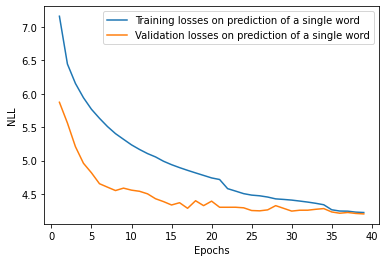

<Figure size 432x288 with 0 Axes>

In [60]:
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses on prediction of a single word')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses on prediction of a single word')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()
plt.savefig('loss.jpg')

In [43]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | also killed , and the men were forced to retreat
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | = = = <eol> Torres was appointed manager of the
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | album , and the second single from the album ,
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | <unk> , and <unk> . <eol> = = = <unk>
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | screw <unk> and could be used to reduce the efficiency
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | <unk> <unk> <unk> , the commander of the <unk> <unk>
Input | 